In [11]:
import pandas as pd
import json
import requests
from urllib.parse import quote
%matplotlib inline 

soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area AS Community, count(*)/5 AS No_Crimes, primary_type AS Primary_Type ")
soql += quote("WHERE 2007 < year AND year < 2013 ")
soql += quote("GROUP BY Community, Primary_Type LIMIT 10000")

resp = requests.get(soql).json()

crime_type = pd.DataFrame(resp)
crime_type.No_Crimes = crime_type.No_Crimes.astype(float)
crime_type.round(1) 

crime_type.dropna(axis = 0, how = "any", inplace = True) 
socioeconomics = pd.read_csv("data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
# rename "community"
crime_type.rename(columns={'Community':'Community Area Number'}, inplace = True)
crime_type['Community Area Number'] = crime_type['Community Area Number'].astype(float)

mix_type = pd.DataFrame.merge(crime_type, socioeconomics, on = 'Community Area Number')
mix_type

,Community Area Number,No_Crimes,Primary_Type,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,4.6,ARSON,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,1.0,344.8,ASSAULT,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2,1.0,1038.6,BATTERY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
3,1.0,279.6,BURGLARY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
4,1.0,630.6,CRIMINAL DAMAGE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
5,1.0,221.0,CRIMINAL TRESPASS,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
6,1.0,22.6,CRIM SEXUAL ASSAULT,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
7,1.0,206.0,DECEPTIVE PRACTICE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
8,1.0,11.0,GAMBLING,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
9,1.0,4.0,HOMICIDE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0


In [4]:
crime_type["Primary_Type"].unique()

array(['ASSAULT', 'BATTERY', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT', 'NARCOTICS',
       'OTHER OFFENSE', 'THEFT', 'ARSON', 'BURGLARY',
       'CRIM SEXUAL ASSAULT', 'GAMBLING', 'HOMICIDE',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'OBSCENITY', 'OFFENSE INVOLVING CHILDREN',
       'PROSTITUTION', 'PUBLIC INDECENCY', 'PUBLIC PEACE VIOLATION',
       'ROBBERY', 'SEX OFFENSE', 'STALKING', 'WEAPONS VIOLATION',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL (SUBJECT SPECIFIED)',
       'NON-CRIMINAL'], dtype=object)

In [5]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

import pytz

from urllib.parse import quote

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

/home/bac2qh/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
homicide = mix_type.loc[(mix_type['Primary_Type'] =='HOMICIDE')]  
#homicide_hardship.head() 
homicide

,Community Area Number,No_Crimes,Primary_Type,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
9,1.0,4.0,HOMICIDE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
36,10.0,0.4,HOMICIDE,Norwood Park,2.0,5.4,9.0,11.5,39.5,32875,21.0
61,11.0,0.6,HOMICIDE,Jefferson Park,2.7,8.6,12.4,13.4,35.5,27751,25.0
87,12.0,0.4,HOMICIDE,Forest Glen,1.1,7.5,6.8,4.9,40.5,44164,11.0
111,13.0,0.8,HOMICIDE,North Park,3.9,13.2,9.9,14.4,39.0,26576,33.0
138,14.0,3.8,HOMICIDE,Albany Park,11.3,19.2,10.0,32.9,32.0,21323,53.0
165,15.0,1.8,HOMICIDE,Portage Park,4.1,11.6,12.6,19.3,34.0,24336,35.0
192,16.0,2.2,HOMICIDE,Irving Park,6.3,13.1,10.0,22.4,31.6,27249,34.0
219,17.0,1.0,HOMICIDE,Dunning,5.2,10.6,10.0,16.2,33.6,26282,28.0
244,18.0,0.8,HOMICIDE,Montclaire,8.1,15.3,13.8,23.5,38.6,22014,50.0


In [12]:
# homicide_hardship = homicide[['HARDSHIP INDEX','No_Crimes']] 
# homicide_hardship.head() 

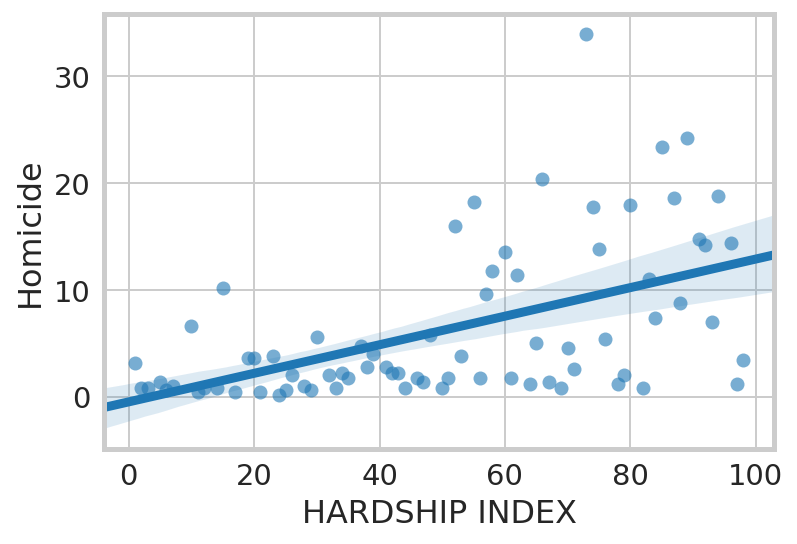

In [24]:
homicide_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = homicide, scatter_kws = {"alpha" : 0.6});
homicide_hardship_plot.set_ylabel('Homicide')
homicide_hardship_plot.figure.savefig("output/homicide_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [59]:
mix_type.Primary_Type.unique()

array(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY', 'CRIMINAL DAMAGE',
       'CRIMINAL TRESPASS', 'CRIM SEXUAL ASSAULT', 'DECEPTIVE PRACTICE',
       'GAMBLING', 'HOMICIDE', 'INTERFERENCE WITH PUBLIC OFFICER',
       'INTIMIDATION', 'KIDNAPPING', 'LIQUOR LAW VIOLATION',
       'MOTOR VEHICLE THEFT', 'NARCOTICS', 'OBSCENITY',
       'OFFENSE INVOLVING CHILDREN', 'OTHER OFFENSE', 'PROSTITUTION',
       'PUBLIC INDECENCY', 'PUBLIC PEACE VIOLATION', 'ROBBERY',
       'SEX OFFENSE', 'STALKING', 'THEFT', 'WEAPONS VIOLATION',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL (SUBJECT SPECIFIED)',
       'NON-CRIMINAL'], dtype=object)

In [60]:
mix_type.columns

Index(['Community Area Number', 'No_Crimes', 'Primary_Type',
       'COMMUNITY AREA NAME', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX'],
      dtype='object')

In [ ]:
socio_dict = {}

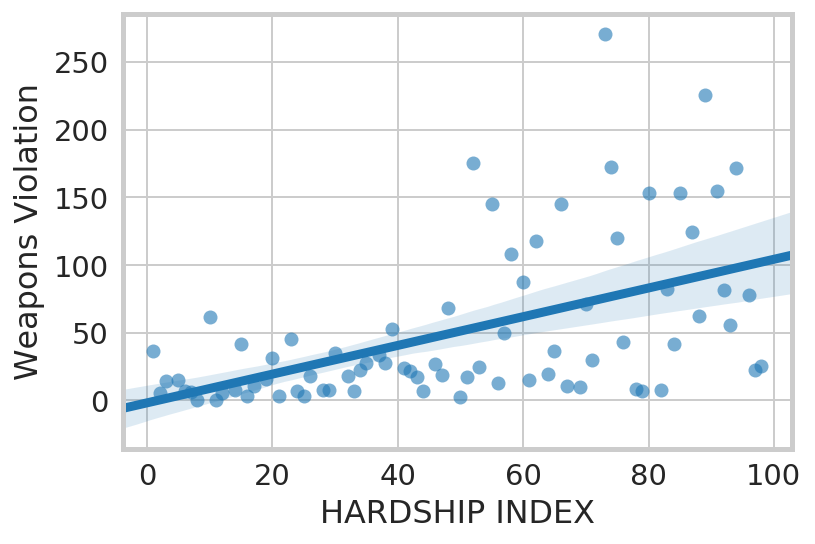

In [25]:
weapons = mix_type.loc[(mix_type['Primary_Type'] =='WEAPONS VIOLATION')]  
weapons_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = weapons, scatter_kws = {"alpha" : 0.6});
weapons_hardship_plot.set_ylabel('Weapons Violation')
weapons_hardship_plot.figure.savefig("output/weapons_hardship.png", bbox_inches='tight', pad_inches=0.2)

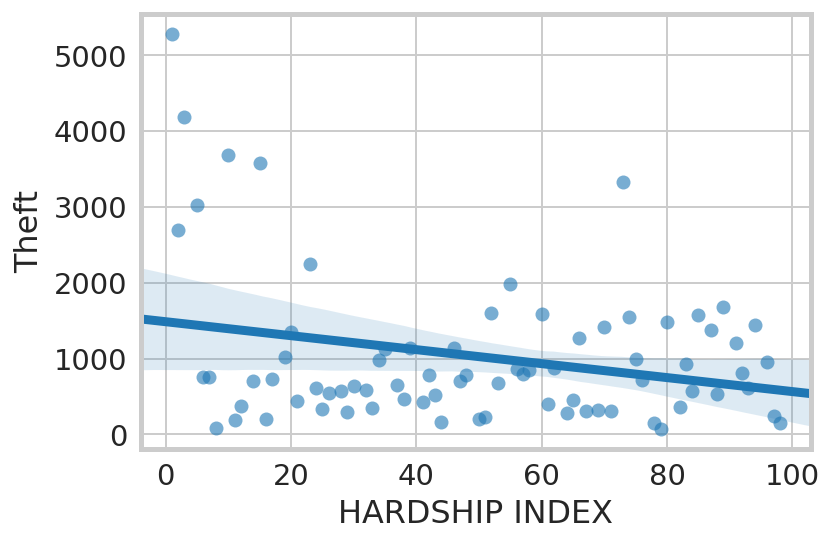

In [49]:
theft = mix_type.loc[(mix_type['Primary_Type'] == 'THEFT')] 
theft_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = theft, scatter_kws = {"alpha" : 0.6});
theft_hardship_plot.set_ylabel('Theft')
theft_hardship_plot.figure.savefig("output/theft_hardship.png",  bbox_inches='tight', pad_inches=0.2)

In [48]:
# theft = mix_type.loc[(mix_type['Primary_Type'] == 'THEFT') | (mix_type['Primary_Type'] == 'MOTOR VEHICLE THEFT')] 
# theft_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = theft, scatter_kws = {"alpha" : 0.6});
# theft_hardship_plot.set_ylabel('Theft')
# # theft_hardship_plot.figure.savefig("theft_hardship.png")

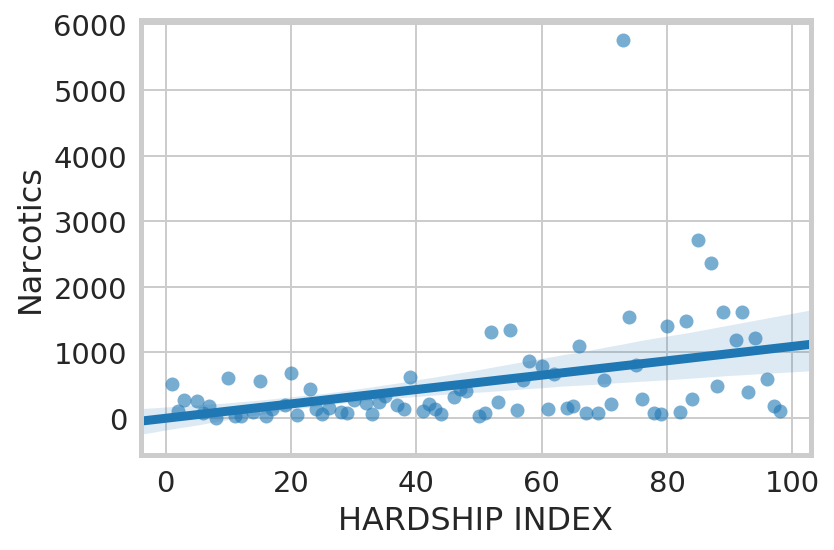

In [51]:
narcotics = mix_type.loc[(mix_type['Primary_Type'] == 'NARCOTICS')]  
narcotics_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = narcotics, scatter_kws = {"alpha" : 0.6});
narcotics_hardship_plot.set_ylabel('Narcotics')
narcotics_hardship_plot.figure.savefig("output/narcotics_hardship.png", bbox_inches='tight', pad_inches=0.2)

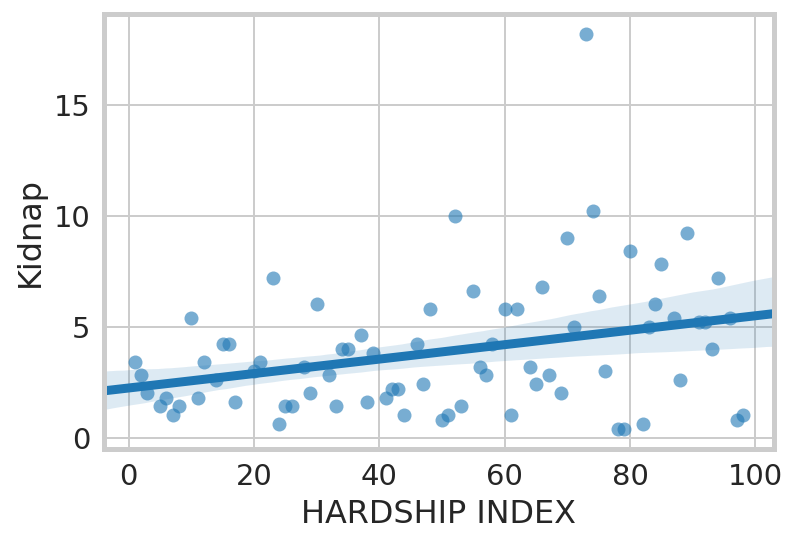

In [53]:
kidnap = mix_type.loc[(mix_type['Primary_Type'] == 'KIDNAPPING')]  
kidnap_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = kidnap, scatter_kws = {"alpha" : 0.6});
kidnap_hardship_plot.set_ylabel('Kidnap')
kidnap_hardship_plot.figure.savefig("output/kidnap_hardship.png", bbox_inches='tight', pad_inches=0.2)

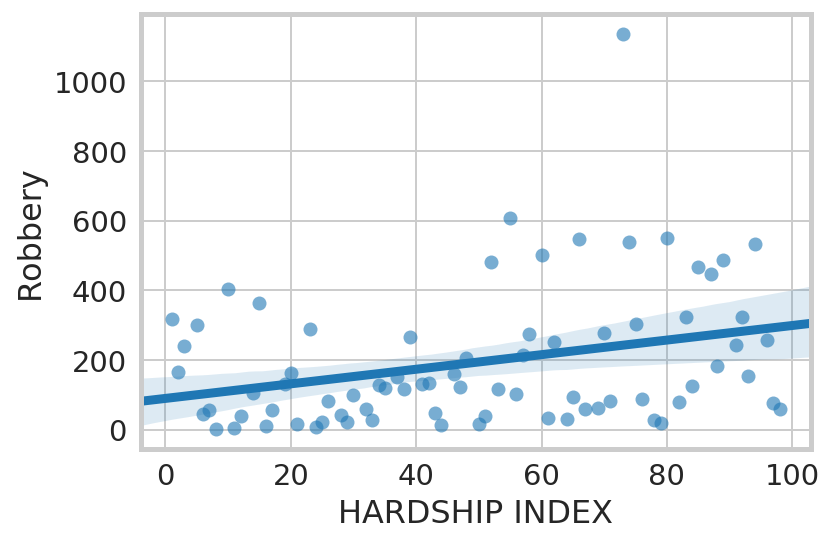

In [55]:
robbery = mix_type.loc[(mix_type['Primary_Type'] == 'ROBBERY')]  
robbery_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = robbery, scatter_kws = {"alpha" : 0.6});
robbery_hardship_plot.set_ylabel('Robbery')
robbery_hardship_plot.figure.savefig("output/robbery_hardship.png", bbox_inches='tight', pad_inches=0.2)

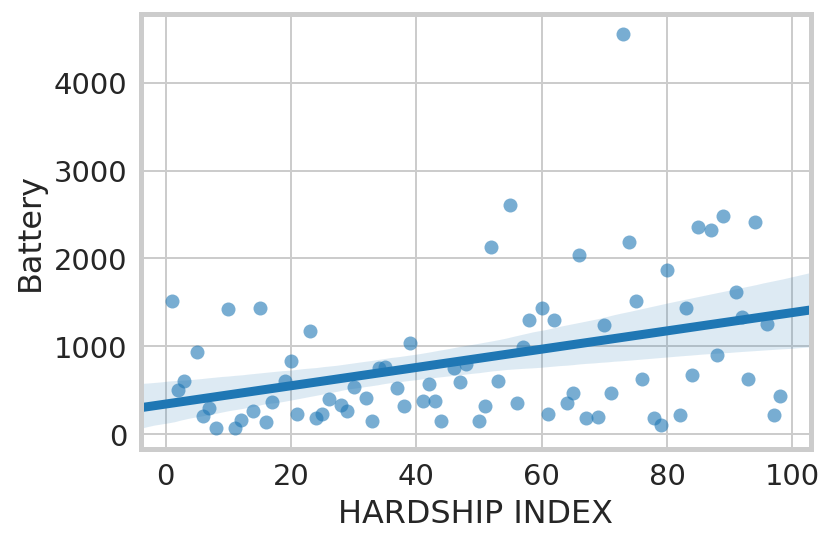

In [56]:
battery = mix_type.loc[(mix_type['Primary_Type'] == 'BATTERY')]  
battery_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = battery, scatter_kws = {"alpha" : 0.6}); 
battery_hardship_plot.set_ylabel('Battery')
battery_hardship_plot.figure.savefig("output/battery_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [24]:
ols_homicide = smf.ols(formula = "Crime ~ Crowd + Poverty + Unemp + Edu + Age +Income",
              data = homicide.rename(columns = {"No_Crimes"                                 : "Crime", 
                                                 "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
                                                 "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
                                                 "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
                                                 "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
                                                 "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
                                                 "PER CAPITA INCOME "                         : "Income",}))
model_homicide = ols_homicide.fit()
model_homicide.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Crime   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     7.463
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           3.67e-06
Time:                        00:05:13   Log-Likelihood:                -234.99
No. Observations:                  75   AIC:                             484.0
Df Residuals:                      68   BIC:                             500.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2023      8.214      0.633      0.529     -11.188      21.593
Crowd          0.9999      0.409      2.443      0.017       0.183       1.817
Poverty        0.0102      0.108      0.095      0.925      -0.206       0.227
Unemp          0.6464      0.197      3.274      0.002       0.252       1.040
Edu           -0.2419      0.146     -1.661      0.101      -0.532       0.049
Age           -0.2189      0.163     -1.340      0.185      -0.545       0.107
Income     -5.609e-05   9.49e-05     -0.591      0.556      -0.000       0.000
==============================================================================
Omnibus:                       18.400   Durbin-Watson:                   1.502
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.432
Skew:                           0.883   Prob(JB):                     9.07e-08
Kurtosis:                       5.695   Cond. No.                     3.60e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

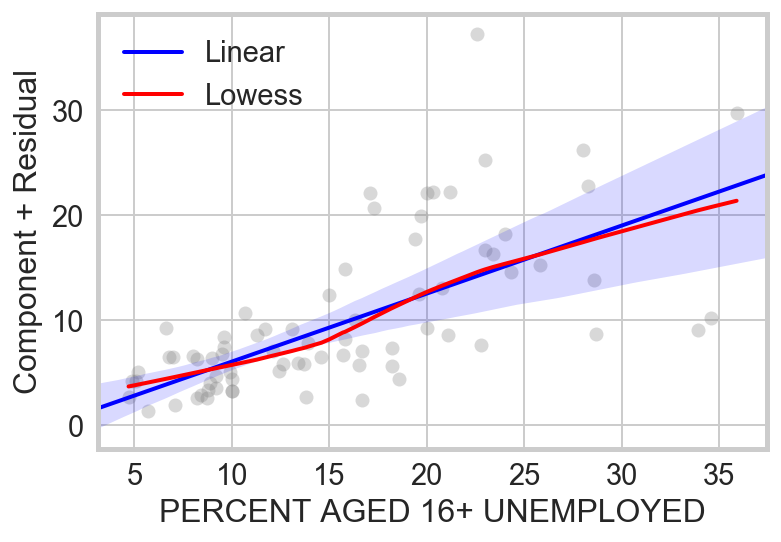

In [31]:
homicide_socio = pd.Series(name = "Component + Residual", data = model_homicide.resid + homicide["PERCENT AGED 16+ UNEMPLOYED"] * model_homicide.
                params["Unemp"])
ax = sns.regplot(x = homicide["PERCENT AGED 16+ UNEMPLOYED"], y = homicide_socio, scatter = True, fit_reg = False,
            scatter_kws = {"alpha" : 0.3, "color" : "grey"})
sns.regplot(x = homicide["PERCENT AGED 16+ UNEMPLOYED"], y = homicide_socio, scatter = False, 
            lowess = False, robust = True, label = "Linear",
            scatter_kws = {"alpha" : 0.3, "color" : "grey"}, line_kws = {"color" : "blue", "linewidth" : 2})
sns.regplot(x = homicide["PERCENT AGED 16+ UNEMPLOYED"], y = homicide_socio, scatter = False, 
            lowess = True, label = "Lowess",
            scatter_kws = {"alpha" : 0}, line_kws = {"color" : "red", "linewidth" : 2}, ax = ax);

ax.legend() 
ax.figure.savefig("homicide_unemp.png")